In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import AutoMinorLocator
from scipy.stats import t as t_dist
plt.rcParams['font.family'] = 'Ubuntu'

from data_processing.functions import combine_summary_dataframes, combine_timing_dataframes, get_stats, xor_columns_ratios, compute_ratios, create_table, get_color

In [12]:
MODE_NAME_CHANGES = {
    "qrng-extraction-qlib": "QuantisLibraries",
    "qrng-extraction-qlib-xor": "QuantisLibraries-XOR",
    "qrng-extraction-qrandom": "devqrandom",
    "qrng-extraction-qrandom-xor": "devqrandom-XOR",
    "no-qrng": "NoQRNG",
    "qrng-extraction-rngtools_reseed1": "rngtools",}

### Some functions definitions

## Req/s (batch) plots and calculations (from summary dataframe)

In [35]:
FREQ_BASE = (1024*1024)*35
MEGABIT_CONVERSION = 8/(1024*1024)


def plot_req_s(input_df, error_column="Req/s_std", several_runs=True, xor_ratios=False, measured_bytes=None, n_clients=None, n_requests=None, plot_title="req_s.png", y_start=None):
    """
    Plots requests per second and optionally data per second for different algorithms and modes.

    :param input_df: DataFrame containing the data to be plotted, with columns for algorithm, mode, Req/s, etc.
    :param several_runs: Boolean, if True, the mean values are plotted and error bars represent standard deviation. Default is True.
    :param xor_ratios: Boolean, if True, the XOR ratios are computed and plotted as subplot. Default is False.
    :param n_clients: Integer, number of clients used, for labeling purposes.
    :param n_requests: Integer, number of requests used, for labeling purposes.
    """
    fontsize_1 = 20
    fontsize_2 = 24

    def mode_order(mode):
        if "qrandom" in mode:
            return 0
        elif "rngtools" in mode:
            return 1
        else:
            return 2

    if several_runs:
        column_suffix = "_mean"
    else:
        column_suffix = ""        

    width = 0.15  # width of the bars
    input_df = input_df.sort_values('algorithm')

    algorithms = input_df["algorithm"].unique()
    x = np.arange(len(algorithms))  # label locations
    mode_data = input_df["mode"].unique()
    req_s_column = f"Req/s{column_suffix}"

    if measured_bytes is not None:
        if True:
            measured_bytes = dict(zip(measured_bytes['algorithm'], measured_bytes['measured_bytes']))
            for alg in algorithms:
                no_qrng_req_s = input_df[(input_df['algorithm'] == alg) & (input_df['mode'] == 'NoQRNG')][req_s_column].values[0]
                delta_t = 1/input_df[input_df['algorithm'] == alg][req_s_column] - 1/no_qrng_req_s
                print()
                input_df.loc[input_df['algorithm'] == alg, req_s_column] = MEGABIT_CONVERSION / (1/FREQ_BASE + delta_t/measured_bytes.get(alg, 1))
                input_df[error_column] = 0

    mode_data = sorted(mode_data, key=lambda mode: input_df[input_df["mode"] == mode][req_s_column].mean(), reverse=False)

    color_palette = list(mcolors.LinearSegmentedColormap.from_list("", ["#9fcf69", "#33acdc"])(np.linspace(0, 1, len(mode_data))))

    if xor_ratios:
        fig, axes = plt.subplots(2, 1, figsize=(12, 8))
        ratio_df = xor_columns_ratios(input_df)
        scatter_y_positions = np.linspace(0, len(algorithms)-1, len(algorithms))
    else:
        fig, axes = plt.subplots(1, 1, figsize=(20, 10))
        input_df = input_df[~input_df["algorithm"].str.contains("frodo|bike|hqc")]


    scatter_plots = []
    base_modes = []

    if measured_bytes is not None:
        mode_data = ["devqrandom-XOR"]

    for i, mode in enumerate(mode_data):
        mode_df = input_df[input_df["mode"] == mode]
        x_position = x - (3/2)*width + i*width

        if xor_ratios:
            bars_container = axes[0].bar(
                x_position,
                mode_df[req_s_column],
                width,
                label=mode,
                zorder=3,
                color=color_palette[i],
                edgecolor='black',
                linewidth=1,
                yerr=mode_df[error_column] if several_runs else None,
                capsize=3,
                error_kw={'ecolor': 'black'}
                )
            if several_runs:
                for line in bars_container.errorbar.lines[2]:
                    line.set_linestyle('dashed')
                    line.set_linewidth(0.75)
            
            if "-xor" in mode:
                base_mode = mode.replace("-xor", "")
                mode_ratios = ratio_df[(ratio_df["algorithm"].isin(algorithms)) & (ratio_df["mode"] == base_mode)]
                axes[1].axhline(y=1, color='red', linestyle='--', linewidth=1, alpha=0.75)

                scatter_errors = axes[1].errorbar(
                    x_position + width/2, 
                    mode_ratios["xor_ratio"], 
                    yerr=mode_ratios["xor_error"], 
                    fmt='none',  
                    color="black", 
                    capsize=3, 
                    zorder=4, 
                    label=f"{base_mode} XOR Ratio"
                )

                for line in scatter_errors.lines[2]:
                    line.set_linestyle('dashed')
                    line.set_linewidth(0.75)
                scatter_plot = axes[1].scatter(x_position + width/2, mode_ratios["xor_ratio"], marker='o', color=color_palette[i], zorder=4, s=20, label=f"{base_mode} XOR Ratio")
                scatter_plots.append(scatter_plot)
                base_modes.append(base_mode)

        else:
            container = axes.bar(
                x_position,
                mode_df[req_s_column],
                width,
                label=mode,
                zorder=3,
                color=color_palette[i],
                edgecolor='black',
                linewidth=1,
                yerr=mode_df[error_column] if several_runs else None,
                capsize=3,
                error_kw={'ecolor': 'black'}
                )
            if several_runs:
                for line in container.errorbar.lines[2]:
                    line.set_linestyle('dashed')
                    line.set_linewidth(0.75)

    if xor_ratios:
        axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(mode_data), frameon=False, fontsize=fontsize_1)
        axes[1].legend(handles=scatter_plots, labels=base_modes, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(scatter_plots), frameon=False, fontsize=fontsize_1)
    else:
        if len(mode_data) <= 4:
            axes.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(mode_data), frameon=False, fontsize=fontsize_1)
        else:
            axes.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2, frameon=False, fontsize=fontsize_1)

    if measured_bytes is not None:
        y_label = "Mbits/s"
        title = f'Estimated generation speed by algorithm'
    else:
        y_label = "Req/s"
        if xor_ratios:
            title = f'Req/s by algorithm'
        else:
            title = f'XOR/no-XOR ratios by algorithm'

    if xor_ratios:
        axes[0].set_ylabel(y_label, weight='bold', fontsize=fontsize_1)
        axes[0].set_title(title, weight='bold', y=1.10)
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(algorithms, rotation=45, horizontalalignment='right')
        axes[0].tick_params(axis='both', labelsize=14)
        axes[0].yaxis.set_label_coords(-0.04, 0.5)
        if y_start is not None:
            axes[0].set_ylim(y_start, None)
        axes[1].set_ylabel(y_label, weight='bold', fontsize=fontsize_2)
        axes[1].set_title(title, weight='bold', y=1.10)
        axes[1].set_xticks(x)
        axes[1].set_xticklabels(algorithms, rotation=45, horizontalalignment='right')
        axes[1].tick_params(axis='both', labelsize=14)
        axes[1].yaxis.set_label_coords(-0.04, 0.5)
    else:
        axes.set_ylabel(y_label, weight='bold', fontsize=fontsize_2)
        axes.yaxis.set_label_coords(-0.065, 0.5)
        axes.set_xticks(x)
        axes.set_xticklabels(algorithms, rotation=45, horizontalalignment='right')
        axes.tick_params(axis='both', labelsize=fontsize_1)

    plt.xlabel('Algorithm', weight='bold', fontsize=fontsize_2)

    if xor_ratios:
        axes[0].yaxis.set_minor_locator(AutoMinorLocator())
        axes[0].xaxis.set_minor_locator(AutoMinorLocator())
        axes[0].grid(True, zorder=0, alpha=0.5)
        axes[0].grid(which='minor', color='black', linestyle=':', linewidth=0.5, alpha=0.3)
        axes[1].yaxis.set_minor_locator(AutoMinorLocator())
        axes[1].xaxis.set_minor_locator(AutoMinorLocator())
        axes[1].grid(True, zorder=0, alpha=0.5)
        axes[1].grid(which='minor', color='black', linestyle=':', linewidth=0.5, alpha=0.3)
    else:
        axes.yaxis.set_minor_locator(AutoMinorLocator())
        axes.xaxis.set_minor_locator(AutoMinorLocator())
        axes.grid(True, zorder=0, alpha=0.5)
        axes.grid(which='minor', color='black', linestyle=':', linewidth=0.5, alpha=0.3)

    if not xor_ratios and y_start is not None:
       axes.set_ylim(y_start, None)
       

    plt.tight_layout()

    if not os.path.isdir("./plots"):
        os.mkdir("./plots")

    plt.savefig(os.path.join(".", "plots", plot_title))
    plt.show()


#### Plotting QRNG no-QRNG Req/s comparison

In [4]:
IS_REVIEW = True
n_clients = 1000
n_requests = 1000
summary_modes_list =  ["qrng-extraction-qrandom-xor", "qrng-extraction-rngtools_reseed1", "no-qrng"]
_, summary_df_all = combine_summary_dataframes(n_clients, n_requests, summary_modes_list, n_runs=100, is_review=IS_REVIEW)
summary_df_all['mode'] = summary_df_all['mode'].map(MODE_NAME_CHANGES)
summary_df_all.head()

,algorithm,mode,Req/s_mean,data/s_MB/s_mean,requests_total_mean,requests_started_mean,requests_done_mean,requests_succeeded_mean,requests_failed_mean,requests_errored_mean,...,data/s_MB/s_std,requests_total_std,requests_started_std,requests_done_std,requests_succeeded_std,requests_failed_std,requests_errored_std,requests_timeout_std,traffic_space_savings (%)_std,Req/s_error
0,P-256,devqrandom-XOR,157.9134,0.1189,1000.0,1000.0,1000.0,1000.0,0.0,0.0,...,0.010239,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.151846,2.340415
1,P-384,devqrandom-XOR,80.8064,0.0603,1000.0,1000.0,1000.0,1000.0,0.0,0.0,...,0.009583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.138107,2.452878
2,P-521,devqrandom-XOR,85.4276,0.0647,1000.0,1000.0,1000.0,1000.0,0.0,0.0,...,0.006428,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.130116,1.691252
3,X25519,devqrandom-XOR,157.1423,0.1192,1000.0,1000.0,1000.0,1000.0,0.0,0.0,...,0.011253,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.134974,2.762031
4,X448,devqrandom-XOR,137.1532,0.1029,1000.0,1000.0,1000.0,1000.0,0.0,0.0,...,0.019295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.137788,5.035686


In [5]:
measured_bytes_csv = "../results/measured_bytes/measurements.csv"
df_measured_bytes = pd.read_csv(measured_bytes_csv)
df_measured_bytes = df_measured_bytes[(df_measured_bytes["clients"] == 1) & (df_measured_bytes["requests"] == 1)]
df_measured_bytes.head()

,clients,requests,algorithm,http_version,measured_bytes
0,1,1,P-256,2,232
1,1,1,P-384,2,536
2,1,1,P-521,2,662
3,1,1,X448,2,256
4,1,1,X25519,2,232


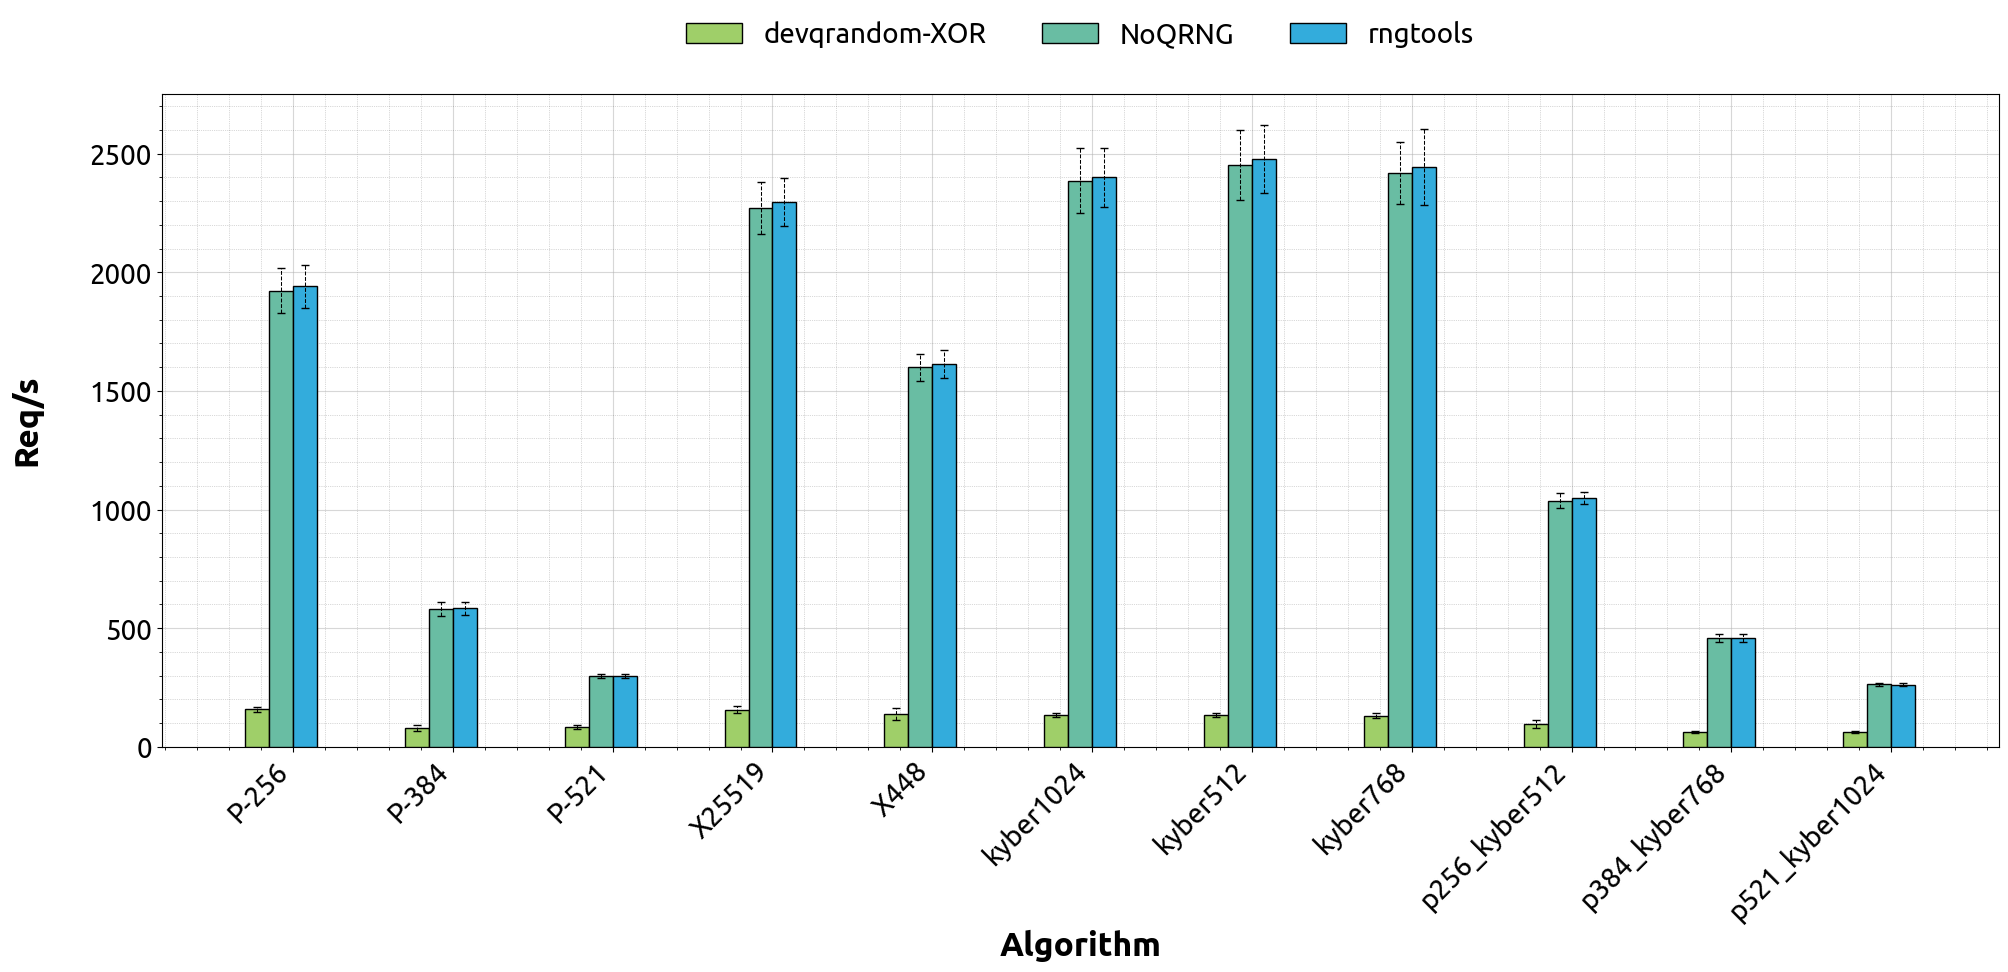

In [14]:
error_column = "Req/s_std"
if error_column == "Req/s_std":
    plot_title = f"{n_clients}_clients_{n_requests}_requests_openssl_vs_linux.png"
elif error_column == "Req/s_error":
    plot_title = f"{n_clients}_clients_{n_requests}_requests_openssl_vs_linux_std_error.png"
else:
    raise Exception("Invalid error column")
if IS_REVIEW:
    plot_title = plot_title.replace(".png", "_review.png")
plot_req_s(summary_df_all, error_column=error_column, several_runs=True, xor_ratios=False, n_clients=n_clients, n_requests=n_requests, plot_title=plot_title)

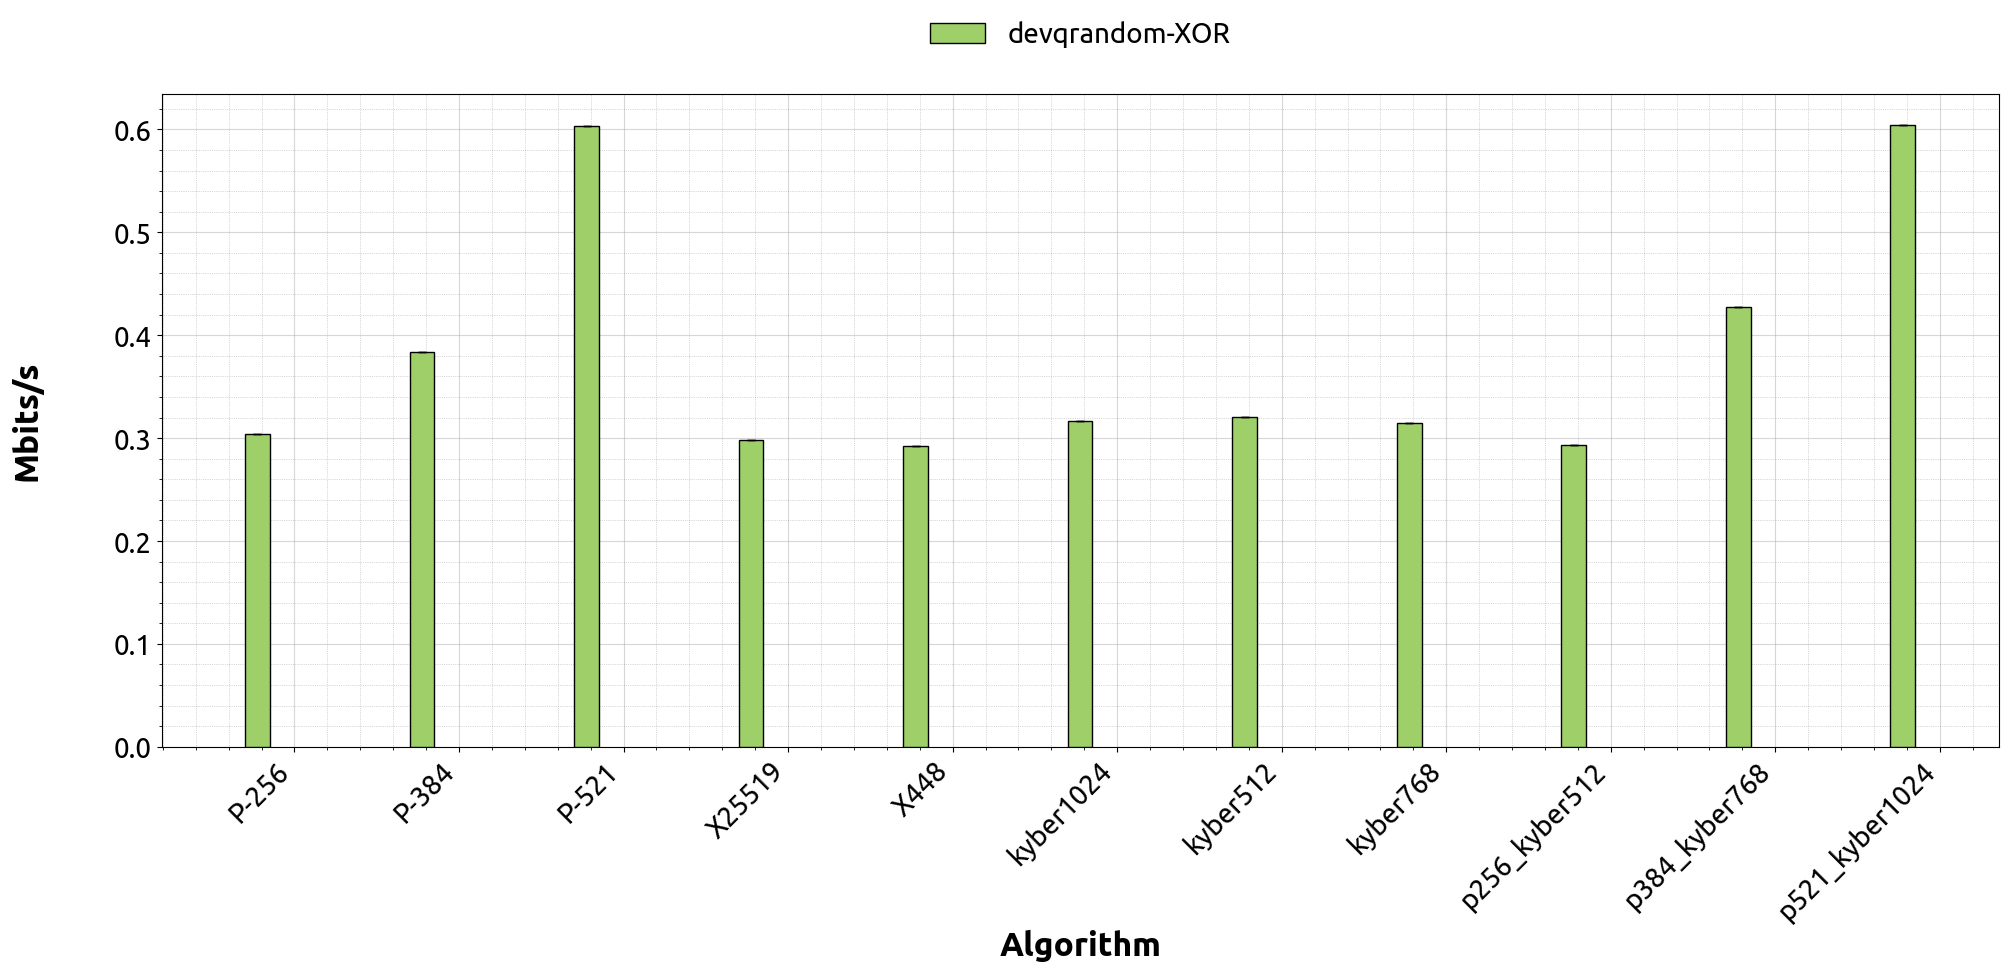

In [36]:
plot_title = f"{n_clients}_clients_{n_requests}_requests_openssl_vs_linux_measured_bytes.png"

plot_req_s(summary_df_all, measured_bytes=df_measured_bytes, error_column=error_column, several_runs=True, xor_ratios=False, n_clients=n_clients, n_requests=n_requests, plot_title=plot_title)

#### Plotting QRNG integration modes Req/s comparison

In [ ]:
qrng_openssl_modes_list =  ["qrng-extraction-qlib", "qrng-extraction-qlib-xor", "qrng-extraction-qrandom", "qrng-extraction-qrandom-xor"]
_, qrng_openssl_df_all = combine_summary_dataframes(n_clients, n_requests, qrng_openssl_modes_list, n_runs=100, is_review=IS_REVIEW)
qrng_openssl_df_all['mode'] = qrng_openssl_df_all['mode'].map(MODE_NAME_CHANGES)
qrng_openssl_df_all.head()

,algorithm,mode,Req/s_mean,data/s_MB/s_mean,requests_total_mean,requests_started_mean,requests_done_mean,requests_succeeded_mean,requests_failed_mean,requests_errored_mean,...,data/s_MB/s_std,requests_total_std,requests_started_std,requests_done_std,requests_succeeded_std,requests_failed_std,requests_errored_std,requests_timeout_std,traffic_space_savings (%)_std,Req/s_error
0,P-256,QuantisLibraries,109.2673,0.08,1000.0,1000.0,1000.0,1000.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.104023
1,P-384,QuantisLibraries,65.2830,0.05,1000.0,1000.0,1000.0,1000.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.226436
2,P-521,QuantisLibraries,65.6946,0.05,1000.0,1000.0,1000.0,1000.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.143414
3,X25519,QuantisLibraries,109.3957,0.08,1000.0,1000.0,1000.0,1000.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.079953
4,X448,QuantisLibraries,108.4712,0.08,1000.0,1000.0,1000.0,1000.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.326041


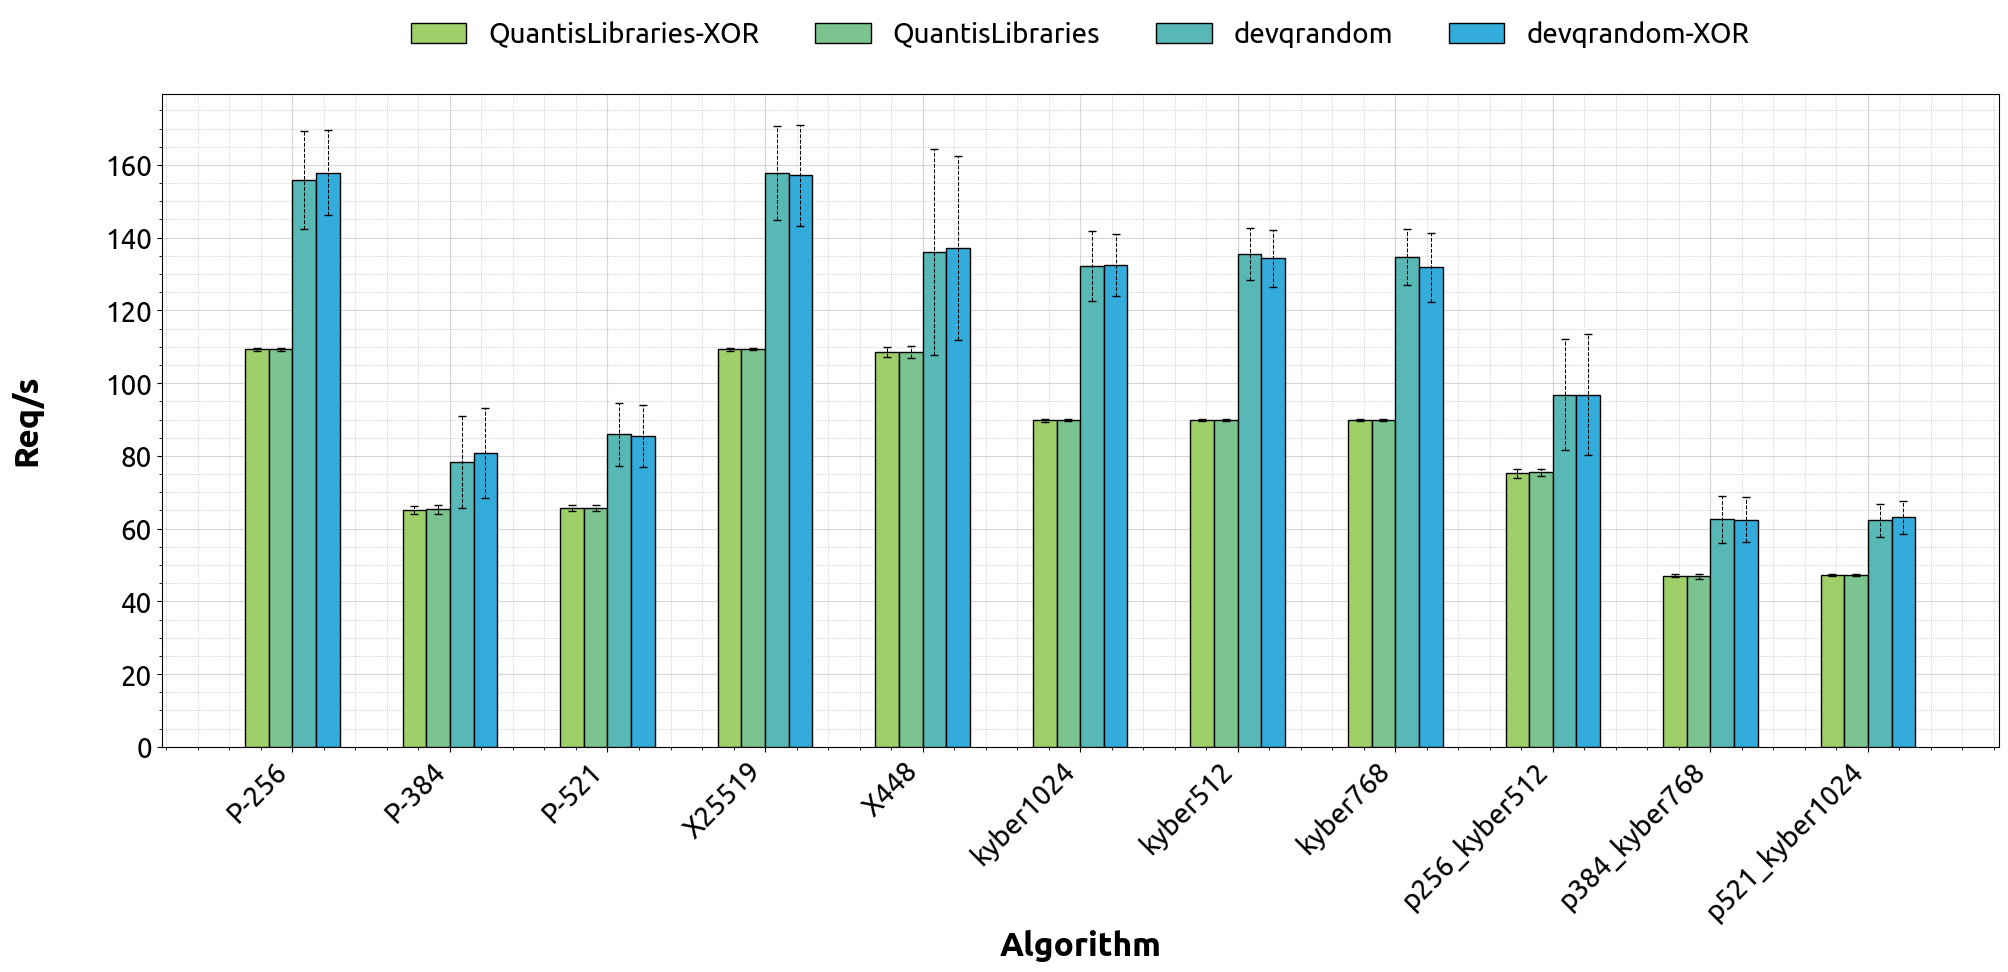

In [ ]:
#error_column = "Req/s_std"
xor_ratios=False
error_column = "Req/s_std"
if error_column == "Req/s_std":
    if xor_ratios:
        plot_title = f"{n_clients}_clients_{n_requests}_openssl_comparison_xor_ratios.png"
    else:
        plot_title = f"{n_clients}_clients_{n_requests}_openssl_comparison.png"
elif error_column == "Req/s_error":
    if xor_ratios:
        plot_title = f"{n_clients}_clients_{n_requests}_openssl_comparison_xor_ratios_std_error.png"
    else:
        plot_title = f"{n_clients}_clients_{n_requests}_openssl_comparison_std_error.png"
else:
    raise Exception("Invalid error column")
if IS_REVIEW:
    plot_title = plot_title.replace(".png", "_review.png")
plot_req_s(qrng_openssl_df_all, error_column=error_column, several_runs=True, xor_ratios=xor_ratios, n_clients=1000, n_requests=1000, plot_title=plot_title)

In [ ]:
summary_df_all[summary_df_all["mode"] == "NoQRNG"]

,algorithm,mode,Req/s_mean,data/s_MB/s_mean,requests_total_mean,requests_started_mean,requests_done_mean,requests_succeeded_mean,requests_failed_mean,requests_errored_mean,...,data/s_MB/s_std,requests_total_std,requests_started_std,requests_done_std,requests_succeeded_std,requests_failed_std,requests_errored_std,requests_timeout_std,traffic_space_savings (%)_std,Req/s_error
22,P-256,NoQRNG,1922.8466,1.4466,1000.0,1000.0,1000.0,1000.0,0.0,0.0,...,0.072672,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.105395
23,P-384,NoQRNG,582.1684,0.4381,1000.0,1000.0,1000.0,1000.0,0.0,0.0,...,0.022369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.775808
24,P-521,NoQRNG,298.7974,0.2248,1000.0,1000.0,1000.0,1000.0,0.0,0.0,...,0.006110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.680282
25,X25519,NoQRNG,2271.3785,1.7087,1000.0,1000.0,1000.0,1000.0,0.0,0.0,...,0.082311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.609538
26,X448,NoQRNG,1598.7647,1.2033,1000.0,1000.0,1000.0,1000.0,0.0,0.0,...,0.043370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.326004
27,kyber1024,NoQRNG,2386.3755,1.7950,1000.0,1000.0,1000.0,1000.0,0.0,0.0,...,0.102341,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.942418
28,kyber512,NoQRNG,2452.7934,1.8457,1000.0,1000.0,1000.0,1000.0,0.0,0.0,...,0.110383,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.088796
29,kyber768,NoQRNG,2418.2479,1.8190,1000.0,1000.0,1000.0,1000.0,0.0,0.0,...,0.097675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.701670
30,p256_kyber512,NoQRNG,1037.7127,0.7813,1000.0,1000.0,1000.0,1000.0,0.0,0.0,...,0.025092,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.588185
31,p384_kyber768,NoQRNG,458.8475,0.3444,1000.0,1000.0,1000.0,1000.0,0.0,0.0,...,0.013282,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.496821


#### Computing the ratios between the QRNG and no-QRNG modes

In [ ]:
ratio_df = compute_ratios(summary_df_all)
latex_table = create_table(ratio_df)

print(latex_table)
print(ratio_df)

\begin{table}[h]
\centering
\caption{Ratios of Req/s between QRNG integration modes with respect to \textit{no-qrng} mode}
\label{tab:ratios}
\begin{tabular}{|c|c|c|}\hline
\textbf{Mode} & \textbf{Average Ratio of Req/s} & \textbf{Error} \\ \hline\hline
\toprule\hline
\midrule\hline
devqrandom-XOR & 11.44 & 0.61 \\\hline
rngtools & 0.99 & 0.03 \\\hline
\bottomrule
\end{tabular}\end{table}
             mode Average Ratio Error
0  devqrandom-XOR         11.44  0.61
1        rngtools          0.99  0.03


### Connection, request and 1s byte times plots and calculations (timing dataframe)

In [ ]:
IS_REVIEW = True
n_clients = 1000
n_requests = 1000
timing_modes_list = ["qrng-extraction-qrandom-xor", "qrng-extraction-rngtools_reseed1", "no-qrng"]
timing_df_all, timing_df_all_reqs  = combine_timing_dataframes(n_clients, n_requests, timing_modes_list, n_runs=100, error_calculation_method=get_stats, is_review=IS_REVIEW)
timing_df_all['mode'] = timing_df_all['mode'].map(MODE_NAME_CHANGES)
timing_df_all.head()

,index,algorithm,mode,weighted_mean,weighted_sd,weighted_t_error,avg_of_means,propagated_t_error,pooled_sd,pooled_t_error,Min (s),Max (s)
0,time for connect,P-256,NoQRNG,0.233091,0.006891,0.001367,0.233008,0.000434,0.070730,0.000438,0.05990,0.48644
1,time for connect,P-256,devqrandom-XOR,1.196495,0.089474,0.017754,1.468600,0.008416,1.396180,0.008654,0.08682,7.35000
2,time for connect,P-256,rngtools,0.229856,0.006936,0.001376,0.229994,0.000436,0.071134,0.000441,0.05841,0.47295
3,time for connect,P-384,NoQRNG,0.997068,0.031784,0.006307,0.997084,0.001974,0.318532,0.001974,0.28921,1.57000
4,time for connect,P-384,devqrandom-XOR,3.429517,0.220359,0.043724,3.510900,0.014516,2.352927,0.014583,0.27343,12.83000


In [ ]:
def plot_connection_times(input_df, mean_column="weighted_mean", sd_column="weighted_t_error", n_clients=None, n_requests=None, plot_tilte="connection_times.png"):

    fontsize_1 = 20
    fontsize_2 = 24

    fig, ax = plt.subplots(figsize=(20, 10))

    input_df = input_df.sort_values('algorithm')
    # remove algorithms containing the substrings "frodo", "bike" and "hqc" from the dataframe
    input_df = input_df[~input_df["algorithm"].str.contains("frodo|bike|hqc")]
    algorithms = input_df["algorithm"].unique()
    x = np.arange(len(algorithms))  # label locations
    unique_modes = input_df["mode"].unique()
    data_types = input_df["index"].unique()
    data_types = ["time for connect", "time to 1st byte"]

    color_palette = list(mcolors.LinearSegmentedColormap.from_list("", ["#9fcf69", "#33acdc"])(np.linspace(0, 1, 3)))

    width = 0.8
    num_modes = len(unique_modes)
    num_data_types = len(data_types)
    bar_width = width / (num_modes * num_data_types)

    unique_modes = sorted(unique_modes, key=lambda mode: input_df[input_df["mode"] == mode][mean_column].mean(), reverse=False)

    for i, mode in enumerate(unique_modes):
        for j, data_type in enumerate(data_types):
            mode_data = input_df[input_df["mode"] == mode]
            mode_data_type = mode_data[mode_data["index"] == data_type]

            mode_color = get_color(color_palette, i, j, num_data_types)
            x_shift = x - width/2 + (j * bar_width) + (i * num_data_types * bar_width)

            container = ax.bar(
                x_shift,
                mode_data_type[mean_column],
                bar_width,
                label=f'{mode} {data_type}',
                color=mode_color,
                yerr=mode_data_type[sd_column],
                edgecolor='black',
                linewidth=1,
                zorder=3,
                capsize=2,
                error_kw={'ecolor': 'black'}
                )
            for line in container.errorbar.lines[2]:
                line.set_linestyle('dashed')
                line.set_linewidth(0.75)

    legend_handles, legend_labels = ax.get_legend_handles_labels()
    num_legend_rows = int(np.ceil(len(legend_labels) / 3))
    ax.legend(
        handles=legend_handles,
        labels=legend_labels,
        fontsize=fontsize_1,
        loc='upper center',
        ncol=3,
        bbox_to_anchor=(0.5, 1.25),
        frameon=False
        )

    ax.set_ylabel('Time (s)',
                weight='bold',
                fontsize=fontsize_2,
                )
    ax.yaxis.set_label_coords(-0.04, 0.5)
    ax.set_xticks(x)
    ax.set_xticklabels(algorithms, rotation=45, horizontalalignment='right')
    ax.tick_params(axis='both', labelsize=fontsize_1)
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    plt.xlabel('Algorithm', weight='bold', fontsize=fontsize_2)
    ax.grid(True, zorder=0, alpha=0.5)
    ax.grid(which='minor', color='black', linestyle=':', linewidth=0.5, alpha=0.3)
    plt.tight_layout()

    if not os.path.isdir("./plots"):
        os.mkdir("./plots")
    plt.savefig(os.path.join(".", "plots", plot_title))
    plt.show()

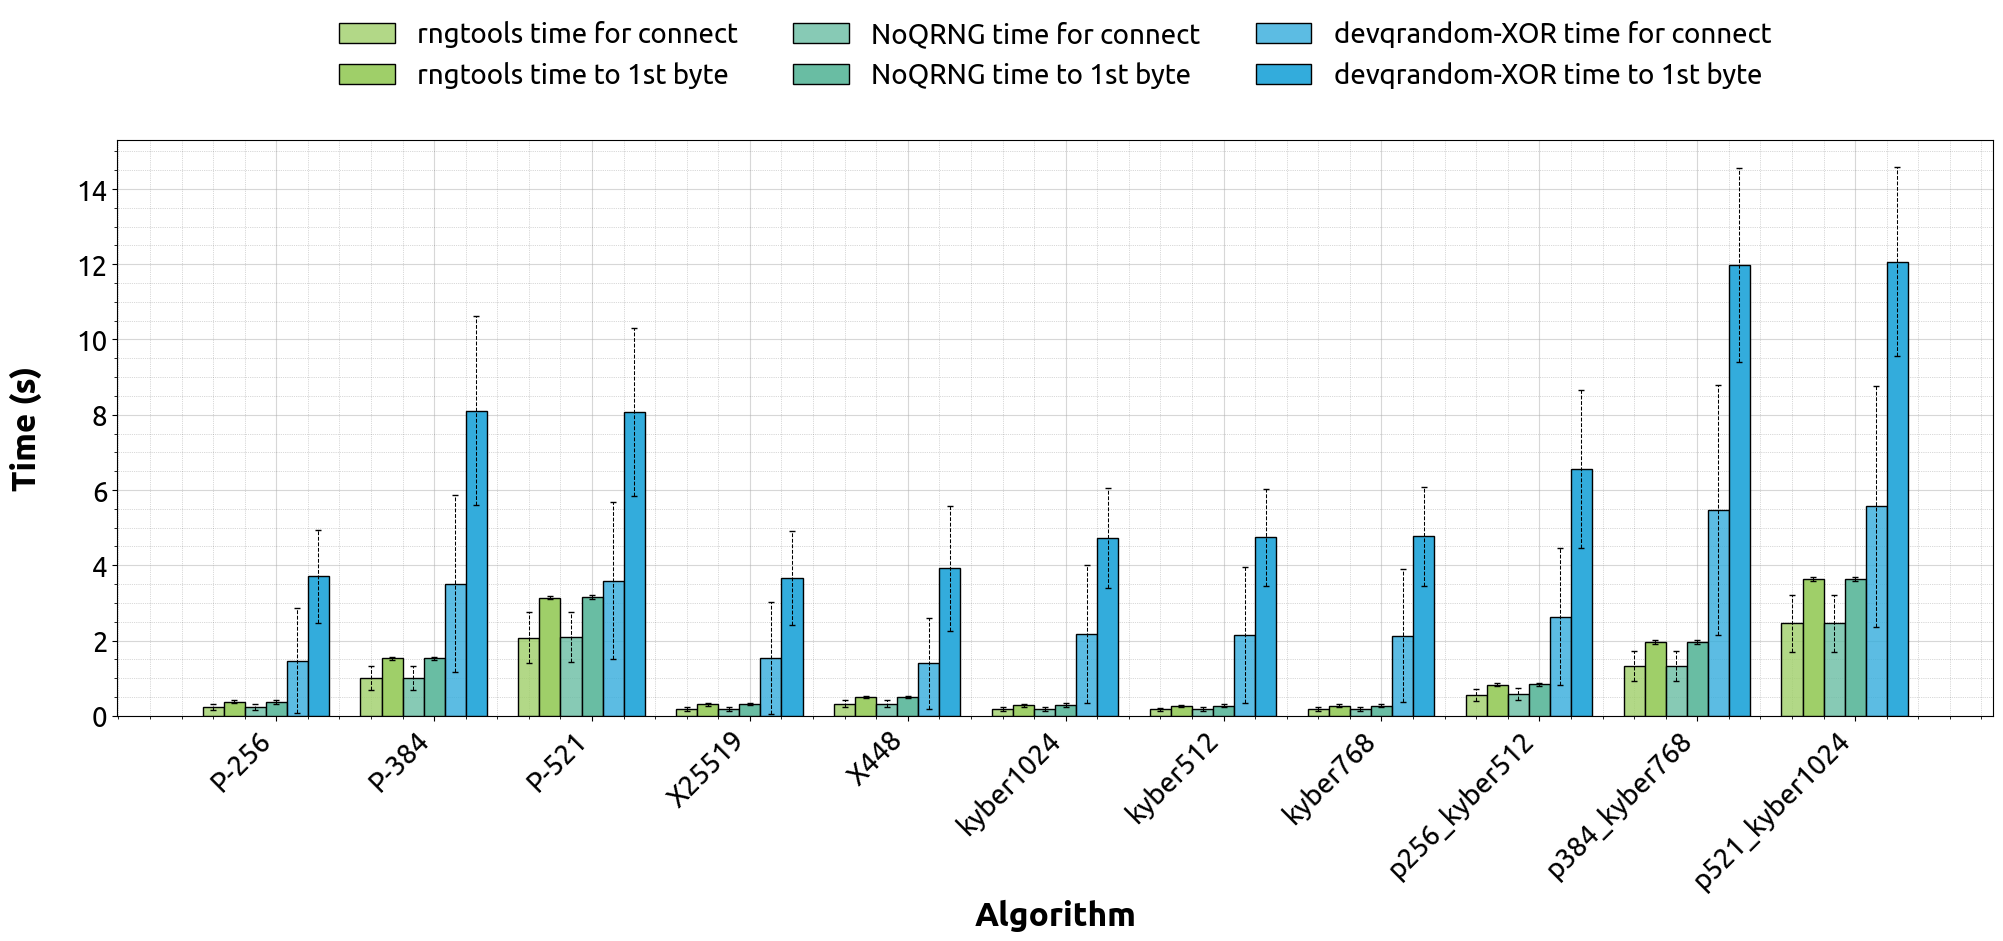

In [ ]:
plot_title=f"{n_clients}_clients_{n_requests}_requests_connection_and_1st_byte_times.png"
if IS_REVIEW:
    plot_title = plot_title.replace(".png", "_review.png")
plot_connection_times(timing_df_all, mean_column="avg_of_means", sd_column="pooled_sd", n_clients=n_clients, n_requests=n_requests, plot_tilte=plot_title)

#### Ratios between connection and 1st byte times ratios with respect to no-qrng mode

In [ ]:
def plot_connection_times_ratios(input_df, n_clients=None, n_requests=None, plot_title="times_ratios.png"):
    mean_column = "weighted_mean"
    sd_column = "weighted_sd"

    fig, ax = plt.subplots(figsize=(12, 6))

    ratio_df = pd.DataFrame(columns=['mode', 'data_type', 'ratio', 'error'])

    no_qrng_data = input_df[input_df["mode"] == "NoQRNG"]
    unique_modes = input_df["mode"].unique()
    data_types = ["time for connect", "time to 1st byte"]

    for mode in unique_modes:
        if mode != "NoQRNG":
            for data_type in data_types:
                mode_data = input_df[(input_df["mode"] == mode) & (input_df["index"] == data_type)]
                no_qrng_data_type = no_qrng_data[no_qrng_data["index"] == data_type]

                ratio = mode_data[mean_column].values / no_qrng_data_type[mean_column].values

                error = abs(ratio) * np.sqrt(
                    (mode_data[sd_column].values / mode_data[mean_column].values) ** 2 +
                    (no_qrng_data_type[sd_column].values / no_qrng_data_type[mean_column].values) ** 2
                )

                row_data = pd.DataFrame({'mode': [mode], 'data_type': [data_type], 'ratio': [ratio[0]], 'error': [error[0]]})
                ratio_df = pd.concat([ratio_df, row_data], ignore_index=True)

    unique_modes = ratio_df["mode"].unique()[::-1]
    x = np.arange(len(unique_modes))

    color_palette = list(mcolors.LinearSegmentedColormap.from_list("", ["#9fcf69", "#33acdc"])(np.linspace(0, 1, 2)))

    width = 0.8
    num_data_types = len(data_types)
    bar_width = width / num_data_types
    unique_modes = [mode for mode in unique_modes if mode != "NoQRNG"]
    for i, mode in enumerate(unique_modes):
        for j, data_type in enumerate(data_types):
            mode_data_type = ratio_df[(ratio_df["mode"] == mode) & (ratio_df["data_type"] == data_type)]

            mode_color = get_color(color_palette, i, j, num_data_types)
            x_shift = i - width/2 + (j * bar_width)

            container = ax.bar(
                x_shift,
                mode_data_type["ratio"],
                bar_width,
                label=f'{mode} {data_type}',
                color=mode_color,
                yerr=mode_data_type["error"],
                edgecolor='black',
                linewidth=1,
                zorder=3,
                capsize=2,
                error_kw={'ecolor': 'black'}
                )
            for line in container.errorbar.lines[2]:
                line.set_linestyle('dashed')
                line.set_linewidth(0.75)

    legend_handles, legend_labels = ax.get_legend_handles_labels()
    num_legend_rows = int(np.ceil(len(legend_labels) / 3))
    ax.legend(
        handles=legend_handles,
        labels=legend_labels,
        fontsize=11,
        loc='upper center',
        ncol=2,
        bbox_to_anchor=(0.5, 1.25),
        frameon=False
        )

    ax.set_ylabel('Ratio', weight='bold', fontsize=12)
    ax.yaxis.set_label_coords(-0.04, 0.5)
    ax.set_xticks(x)
    ax.set_xticklabels(unique_modes, horizontalalignment='right')
    ax.tick_params(axis='both', labelsize=11)
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    plt.xlabel('Mode', weight='bold', fontsize=12)
    ax.grid(True, zorder=0, alpha=0.5)
    ax.grid(which='minor', color='black', linestyle=':', linewidth=0.5, alpha=0.3)
    plt.tight_layout()
    if not os.path.isdir("./plots"):
        os.mkdir("./plots")
    plt.savefig(os.path.join(".", "plots", plot_title))
    plt.show()

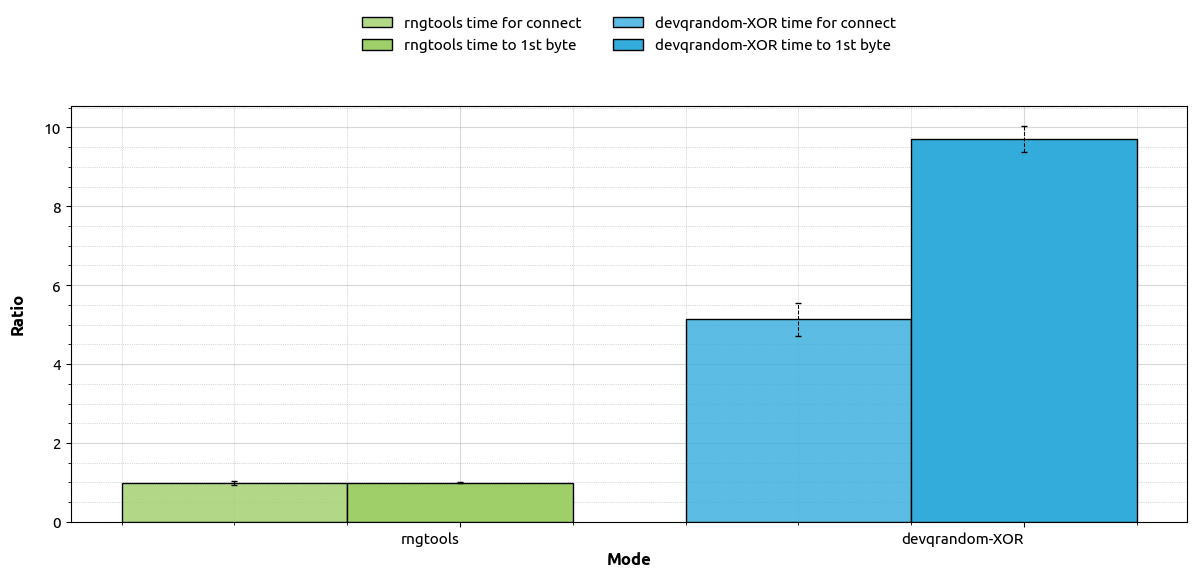

In [ ]:
plot_title = f"{n_clients}_clients_{n_requests}_requests_connection_and_1st_byte_times_ratios.png"
plot_connection_times_ratios(timing_df_all, n_clients=n_clients, n_requests=n_requests)